# Plots

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['font.size'] = 20
from matplotlib import cm as cmx
import matplotlib.colors as colors
import numpy as np
import pickle
import glob

def load_obj(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [13]:
atomic_all = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_atomic/cm/best_all_atomic.txt')
atomic_C = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_atomic/cm/best_atomic_C.txt')
atomic_N = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_atomic/cm/best_atomic_N.txt')
atomic_O = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_atomic/cm/best_atomic_O.txt')

atomic_H = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_H.txt')


alchpots_C = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_C.txt')

In [10]:
atomic2 = atomic_C.copy()
atomic2[:,1] = atomic_C[:,1]/6
atomic2[:,2] = atomic_C[:,2]/6

In [16]:
# datasets = [atomic_all, atomic_C, alchpots_C, atomic2]
# labels = ['all', r'$E_{\rm{C}}$', r'$\mu{\rm{C}}$', 'atomic 2']

datasets = [atomic_all, atomic_H, atomic_C, atomic_N, atomic_O]
labels = ['all', r'$E_{\rm{H}}$', r'$E_{\rm{C}}$', r'$E_{\rm{N}}$', r'$E_{\rm{O}}$']

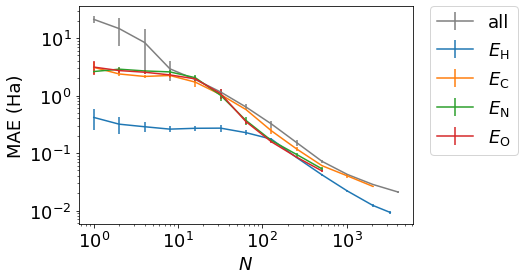

In [19]:
fig, ax = plt.subplots(1,1)
# plt.rcParams.update({'errorbar.capsize': 0})
plt.rcParams.update({'font.size': 18})

for d,l in zip(datasets, labels):
    if l == "all":
        ax.errorbar(d[:,0], d[:,1], d[:,2], label=l, color = "tab:grey")
    else:
        ax.errorbar(d[:,0], d[:,1], d[:,2], label=l)

ax.set_xlabel('$N$')
ax.set_ylabel('MAE (Ha)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#### Plot E_H vs E_molecule

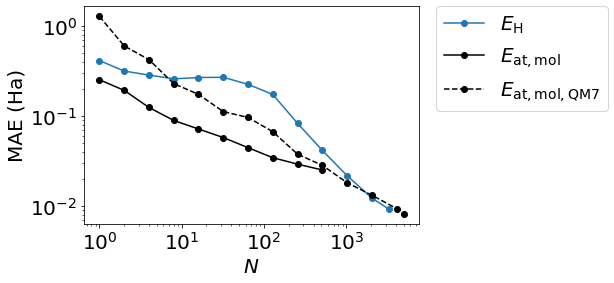

In [10]:
alchpots_H = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_H.txt')
atomisation_molecule = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/reference/l_curve_global_global.tab')
atomisation_molecule_qm7 = np.loadtxt('/home/misa/lectures/computational_materials_design/lcurve.dat')


datasets = [alchpots_H, 
            atomisation_molecule, atomisation_molecule_qm7]
labels = [r'$E_{\rm{H}}$', 
          r'$E_{\rm{at, mol}}$', r'$E_{\rm{at, mol, QM7}}$']

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1,1)
# plt.rcParams.update({'errorbar.capsize': 0})

for d,l in zip(datasets, labels):
    if l == r'$E_{\rm{H}}$':
        ax.plot(d[:,0], d[:,1], '-o', label=l, color = "tab:blue")
    elif l == r'$E_{\rm{at, mol}}$':
        ax.plot(d[:,0], d[:,1], '-o', label=l, color = "black")
    elif l == r'$E_{\rm{at, mol, QM7}}$':
        ax.plot(d[:,0], d[:,1], '--o', label=l, color = "black")

ax.set_xlabel(r'$N$')
ax.set_ylabel('MAE (Ha)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Learning curves for atomic energies

In [ ]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='atomic')

all_local_reps = qmi.generate_atomic_representations(data, molecule_size)

In [ ]:
sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 10

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 12, 13, base=2).astype(int)

for sigma in sigmas:
    error_cv = []
    error_std = []
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = crossvalidate(all_local_reps, alch_pots, tr_size, sigma, lam_val, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
# save best learning curve
lowest_error = (None, None)
for k in lcurves.keys():
    if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
        lowest_error = (k, np.amin(lcurves[k][:,1]))
save_data = lcurves[lowest_error[0]]

# filename
path = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_atomic/cm/best_all_atomic.txt'

sig_val = lowest_error[0].split('_')[1]
header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
np.savetxt(path, save_data, delimiter='\t', header=header)

# save dictionary of learning curves at all sigmas
fname = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_atomic/cm/all_sigma_all_atomic.txt'
save_obj(lcurves, fname)

### Learning curves for atomic energy of single elements

In [1]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def get_tr_size(data_size):
    """
    largest number of training points is roughly 90% of complete data (largest multiple of 2 that is <= 90%)
    """
    largest_set = int(np.log2(data_size*0.9))
    tr_size = np.logspace(0, largest_set, largest_set+1, base=2).astype(int)
    return(tr_size)

def get_element_symbol(Z):
    if int(Z) == 1:
        return('H')
    elif int(Z) == 6:
        return('C')
    elif int(Z) == 7:
        return('N')
    elif int(Z) == 8:
        return('O')
    else:
        raise ValueError('Symbol for given charge not available')

In [2]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='atomic')

all_local_reps = qmi.generate_atomic_representations(data, molecule_size)

# split up alchemical potential by element
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')
idc_by_charge = qmi.partition_idx_by_charge(charges)

el_reps =dict()
el_alch_pots = dict()
for k in idc_by_charge.keys():
    el_reps[k] = all_local_reps[idc_by_charge[k]]
    el_alch_pots[k] = alch_pots[idc_by_charge[k]]

In [4]:
sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 3

for charge in [7.0]:#el_reps.keys():
    lcurves = dict()

    # define number of training points for which MAE is calculated
    set_sizes = get_tr_size(len(el_alch_pots[charge]))
    
    # special for H
#     set_sizes = np.concatenate((set_sizes, np.array([3300])))

    for sigma in sigmas:
        error_cv = []
        error_std = []
        # calculate error for every training point size
        for idx, tr_size in enumerate(set_sizes):
            err, err_std = crossvalidate(el_reps[charge], el_alch_pots[charge], tr_size, sigma, lam_val, num_cv)
            error_cv.append(err)
            error_std.append(err_std)

        lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T
        
    
    # save best learning curve
    lowest_error = (None, None)
    for k in lcurves.keys():
        if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
            lowest_error = (k, np.amin(lcurves[k][:,1]))
    save_data = lcurves[lowest_error[0]]

    # filename
    el_symbol = get_element_symbol(charge)
    path = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_atomic/cm/best_atomic_{el_symbol}.txt'

    sig_val = lowest_error[0].split('_')[1]
    header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
    np.savetxt(path, save_data, delimiter='\t', header=header)

    # save dictionary of learning curves at all sigmas
    fname = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_atomic/cm/all_sigma_atomic_{el_symbol}.txt'
    save_obj(lcurves, fname)